# Genetic Algorithm Approach

In [1]:
import pennylane as qml
from pennylane import numpy as np
from tensorflow import keras
import tensorflow as tf
import matplotlib.pyplot as plt
import random
import math
import collections

In [2]:
tf.config.set_visible_devices([], 'GPU')

## Hyperparameters

In [3]:
num_qubits = 4
batch_size = 1
n_epochs = 20
n_train = 30  
n_test = 20

population_size = 100
iterations = 10
lr = 0.01

## Genetic Algorithm Components

In [4]:
dev = qml.device('lightning.qubit', wires=4)

@qml.qnode(dev, interface="tf", diff_method="adjoint")
def circuit(inputs, gates):
    # Encoding of 4 classical input values
    for j in range(num_qubits):
        qml.RY(np.pi * inputs[j], wires=j)
    
    # Chromosome    
    for gate in gates:
        qml.apply(gate)

    # Measurement producing 4 classical output values
    return [qml.expval(qml.PauliZ(j)) for j in range(num_qubits)]

In [5]:
def extract_all_patches(images):
    patches = tf.image.extract_patches(
        images=images,
        sizes=[1, 2, 2, 1],
        strides=[1, 2, 2, 1],
        rates=[1, 1, 1, 1],
        padding='VALID'
    )
    
    return patches

def quanvolute_train_test(train_images, test_images, gates):
    train_patches = extract_all_patches(train_images)
    test_patches = extract_all_patches(test_images)
    
    train_batches = tf.reshape(train_patches, [-1,4])
    test_batches = tf.reshape(test_patches, [-1,4])
    
    quanvoluted_train_images = tf.stack([circuit(patch, gates) for patch in train_batches])
    quanvoluted_test_images = tf.stack([circuit(patch, gates) for patch in test_batches])

    q_train_images = tf.reshape(quanvoluted_train_images, [len(train_images), 14, 14, 4])
    q_test_images = tf.reshape(quanvoluted_test_images, [len(test_images), 14, 14, 4])
        
    q_train_images = np.asarray(q_train_images)
    q_test_images = np.asarray(q_test_images)
    
    return q_train_images, q_test_images

In [6]:
def initialize_and_save_weights(layer, initializer):
    weights = [initializer(shape) for shape in layer.get_weights()]
    layer.set_weights(weights)
    return weights  # Store the generated weights

# In your reset_weights function
def reset_weights(model):
   for layer in model.layers:
       if isinstance(layer, keras.layers.Dense):
           layer.set_weights(saved_weights) 

In [7]:
def QNN():
    optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=lr) 
    
    model = keras.models.Sequential([
        keras.layers.Flatten(),
        keras.layers.Dense(10, activation="softmax")
    ])

    model.compile(
        optimizer=optimizer,
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

desired_initializer = keras.initializers.HeNormal
saved_weights = initialize_and_save_weights(keras.layers.Dense(10), desired_initializer)

In [8]:
def load_dataset(train_size, test_size):
    mnist_dataset = keras.datasets.mnist
    (train_images, train_labels), (test_images, test_labels) = mnist_dataset.load_data()

    # --- Train Set ---
    train_idx_by_class = [np.where(train_labels == i)[0] for i in range(10)]  
    train_idx_selected = [
        np.random.choice(idxs, min(len(idxs), train_size // 10), replace=False)  # Adjusted for train_size
        for idxs in train_idx_by_class
    ]
    train_idx_selected = np.concatenate(train_idx_selected) 

    train_images = train_images[train_idx_selected]
    train_labels = train_labels[train_idx_selected]

    # --- Test Set --- (Apply the same logic)
    test_idx_by_class = [np.where(test_labels == i)[0] for i in range(10)] 
    test_idx_selected = [
        np.random.choice(idxs, min(len(idxs), test_size // 10), replace=False)  # Adjusted for test_size
        for idxs in test_idx_by_class
    ]
    test_idx_selected = np.concatenate(test_idx_selected) 

    test_images = test_images[test_idx_selected]
    test_labels = test_labels[test_idx_selected]

    # Normalize pixel values within 0 and 1
    train_images = train_images / 255.0
    test_images = test_images / 255.0

    # Add extra dimension for convolution channels
    train_images = np.array(train_images[..., tf.newaxis], requires_grad=False)
    test_images = np.array(test_images[..., tf.newaxis], requires_grad=False)
    
    #new_height = 14  # 28 / 2
    #new_width = 14  # 28 / 2 
    #train_images = tf.image.resize(train_images, (new_height, new_width))
    #test_images = tf.image.resize(test_images, (new_height, new_width))
    
    return train_images, train_labels, test_images, test_labels

train_images, train_labels, test_images, test_labels = load_dataset(n_train, n_test)

Counter({0: 3, 1: 3, 2: 3, 3: 3, 4: 3, 5: 3, 6: 3, 7: 3, 8: 3, 9: 3})


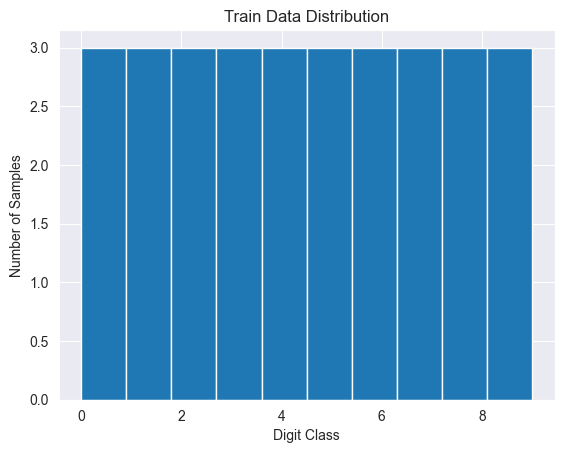

In [9]:
label_counts = collections.Counter(train_labels)
print(label_counts)

plt.hist(train_labels)
plt.xlabel('Digit Class')
plt.ylabel('Number of Samples')
plt.title('Train Data Distribution')
plt.show()

Counter({0: 2, 1: 2, 2: 2, 3: 2, 4: 2, 5: 2, 6: 2, 7: 2, 8: 2, 9: 2})


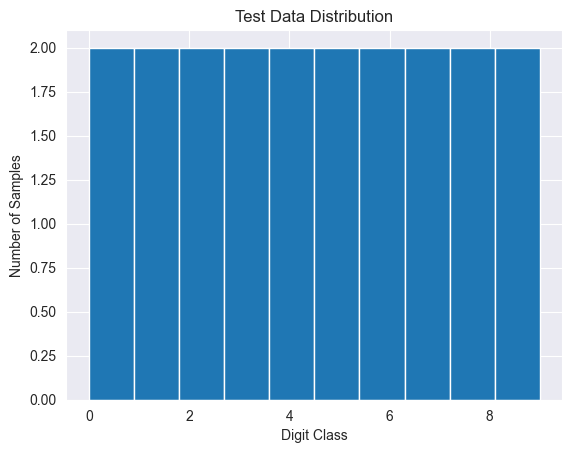

In [10]:
label_counts = collections.Counter(test_labels)
print(label_counts)

plt.hist(test_labels)
plt.xlabel('Digit Class')
plt.ylabel('Number of Samples')
plt.title('Test Data Distribution')
plt.show()

In [11]:
tf.random.set_seed(137)
random.seed(137)  
np.random.seed(137)  

def evaluate_network(gates):
    q_train, q_test = quanvolute_train_test(train_images, test_images, gates)
    model = QNN()
    
    reset_weights(model)
    hist = model.fit(q_train, train_labels, validation_data = (q_test, test_labels), batch_size = batch_size, epochs=n_epochs, verbose=False)
    
    return hist.history['val_accuracy'][-1]

In [12]:
non_param_gates = [qml.CNOT, qml.T, qml.Hadamard]
param_gates = [qml.RX, qml.RZ]

In [13]:
def generate_random_angle():
    random_number = random.random()  # Generates a random float between 0 and 1
    angle = random_number * 2 * math.pi 
    return angle

def random_non_param_gate(n_wires):
    gate = np.random.choice(non_param_gates)
    
    if gate == qml.CNOT:
        wire1 = np.random.randint(n_wires)
        wire2 = np.random.choice([i for i in range(n_wires) if i != wire1])
        return gate(wires = [wire1, wire2])
    else:
        return gate(wires=np.random.randint(n_wires))

def random_param_gate(n_wires):
    gate = np.random.choice(param_gates)
    return gate(generate_random_angle(), wires=np.random.randint(n_wires))

In [14]:
def generate_random_gate_sequence(n_wires, depth):
    gates = []
    for i in range(depth):
        if np.random.rand() < 0.6:
            gate = random_non_param_gate(n_wires)
            gates.append(gate)
        else:
            gate = random_param_gate(n_wires)
            gates.append(gate)
    return gates

[RZ(0.4546925961808592, wires=[3]), RX(2.5767036351215973, wires=[1]), Hadamard(wires=[3]), RZ(6.22195388519651, wires=[3]), RX(1.4509273233499869, wires=[0])]


/var/folders/vw/hv55q7kn1vl9cm96jf24vpkh0000gn/T/ipykernel_28428/1111674411.py:4: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


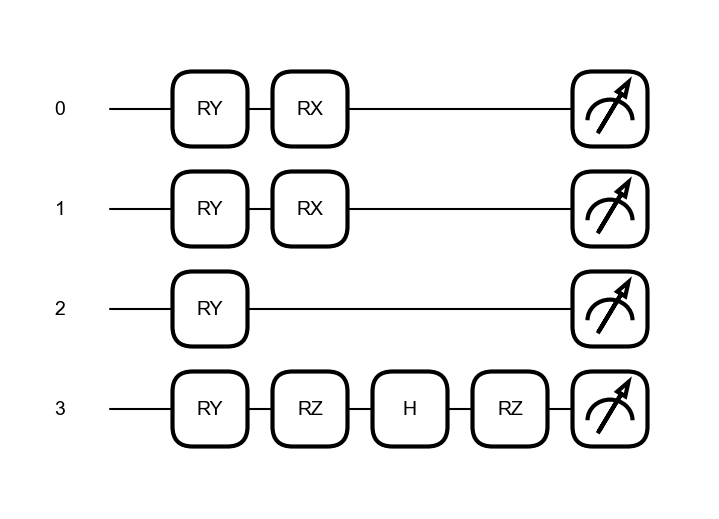

In [15]:
circ = generate_random_gate_sequence(4, 5)
print(circ)
fig, ax = qml.draw_mpl(circuit)([1.0,4,54,44], circ)
fig.show()

In [16]:
# Even though we set the same weights as a starting point we'll get different results for 
# a circuit over different runs, this is due the optimizer being stochastic.
for _ in range(10):
    print(evaluate_network(circ))

0.5
0.5
0.6000000238418579
0.5
0.44999998807907104
0.550000011920929
0.6000000238418579
0.550000011920929
0.550000011920929
0.6000000238418579


## Genetic Operators

In [17]:
def fitness(gates):
    return evaluate_network(gates)

def tournament_selection(population, tournament_size=3):
    """Selects a parent by sampling 'tournament_size' individuals randomly. 
       Assumes population is a list of (individual, fitness) tuples.
    """
    participants = np.random.choice(len(population), tournament_size, replace=False)
    best_candidate_idx = participants[np.argmax([population[p][1] for p in participants])]  # Access fitness with [1]
    return population[best_candidate_idx]  # Return the entire (individual, fitness) tuple

def one_point_crossover(parent1, parent2):
    """Performs one-point crossover between two circuits. 
       Assumes parents are individuals.
    """
    crossover_point = np.random.randint(1, min(len(parent1), len(parent2))) 
    offspring1_circuit = parent1[:crossover_point] + parent2[crossover_point:]
    offspring2_circuit = parent2[:crossover_point] + parent1[crossover_point:]
    return offspring1_circuit, offspring2_circuit  

def kth_point_crossover(parent1, parent2, k):
    """Performs kth-point crossover between
        two circuits
       Assumes parents are individuals
    """
    if k < 1:
        raise ValueError("k (number of crossover points) must be at least 1")

    length = min(len(parent1), len(parent2))

    # Generate k random crossover points within the length of the parents
    crossover_points = sorted(np.random.choice(range(1, length), size=k, replace=False))

    # Initialize offspring with alternating segments
    offspring1_circuit = parent1.copy() 
    offspring2_circuit = parent2.copy()
    current_parent = 1  # Start with parent1

    # Iterate through crossover points, swapping segments 
    for i in range(len(crossover_points)):
        start = crossover_points[i - 1] if i > 0 else 0
        end = crossover_points[i]

        if current_parent == 1:
            offspring1_circuit[start:end] = parent2[start:end]
            offspring2_circuit[start:end] = parent1[start:end]
        else:
            offspring1_circuit[start:end] = parent1[start:end]
            offspring2_circuit[start:end] = parent2[start:end]

        current_parent = (current_parent + 1) % 2  # Switch parents

    return offspring1_circuit, offspring2_circuit  


def simple_mutation(individual, mutation_rate=0.05, n_wires=4):
    """Mutates a circuit with a certain probability per gate.
       Assumes parents are individuals.
    """
    for i in range(len(individual)):
        if np.random.rand() < mutation_rate:
            if np.random.rand() < 0.33:
                individual[i] = random_param_gate(n_wires)
            else:
                individual[i] = random_non_param_gate(n_wires)

    return individual  

def mutate_circuit(circuit, n_wires = 4):
        gate_to_mutate = np.random.choice(range(len(circuit)))
        
        circuit[gate_to_mutate] = generate_random_gate_sequence(n_wires, 1)[0]
        
        return circuit, fitness(circuit)

import time
def genetic_algorithm(n_wires, depth, pop_size, n_generations):
    initial_time = time.time()
    population = [(generate_random_gate_sequence(n_wires, np.random.randint(low=3, high=depth)), 0) for _ in range(pop_size)]
    
    #initial_good_circuit = [qml.RZ(5.466019080616874, wires=[2]), qml.CNOT(wires=[1, 3]),
    #                        qml.RZ(4.966039957106654, wires=[0])]

    #population.append(initial_good_circuit)
    
    for i in range(pop_size):
        population[i] = (population[i][0], fitness(population[i][0]))
    
    population = sorted(population, key=lambda x:x[1], reverse=True)
    
    print(f"Generation {0}:\n\tBest Accuracy: {population[0][1]}\n\tBest Candidate: {max(population, key=lambda x: x[1])[0]}\n\tAverage Accuracy: {np.mean([x[1] for x in population])}")  
    print("\tTime taken: {0:.2f}s".format(time.time() - initial_time))
    for k in range(n_generations):
        start_time = time.time()
        offspring = []

        for _ in range(pop_size // 2):
            parent1 = tournament_selection(population)  
            parent2 = tournament_selection(population)

            offspring1, offspring2 = kth_point_crossover(parent1[0], parent2[0], 2)
            offspring1_fitness = fitness(offspring1)  
            offspring2_fitness = fitness(offspring2)
            
            offspring.append((offspring1, offspring1_fitness)) 
            offspring.append((offspring2, offspring2_fitness))
    
        population = population + offspring
        
        mutations = []
        for circuit in population:
            if np.random.rand() < 0.5:
                mutated_circuit, mutated_fitness = mutate_circuit(circuit[0])
                mutations.append((mutated_circuit, mutated_fitness))
        
        population = population + mutations 
        population = sorted(population, key=lambda x: x[1], reverse=True) 

        # Keep only the top individuals
        population = population[:pop_size]  

        best = population[0]
        worst = population[-1]
        print(f"Generation {k + 1}:\n\tBest Accuracy: {best[1]}\n\tBest Candidate: {best[0]}\n\tAverage Accuracy: {worst[1]}")  
        print("\tTime taken: {0:.2f}s".format(time.time() - start_time))

    return population


final_population = genetic_algorithm(n_wires=4, depth=7, pop_size=population_size, n_generations=iterations) 

Generation 0:
	Best Accuracy: 0.699999988079071
	Best Candidate: [T(wires=[0]), RZ(2.2040382202174, wires=[2]), RX(1.544912313783498, wires=[2]), Hadamard(wires=[3])]
	Average Accuracy: 0.5205000042915344
	Time taken: 1223.87s
Generation 1:
	Best Accuracy: 0.699999988079071
	Best Candidate: [T(wires=[0]), RZ(2.2040382202174, wires=[2]), RX(1.544912313783498, wires=[2]), Hadamard(wires=[3])]
	Average Accuracy: 0.6000000238418579
	Time taken: 2703.66s
Generation 2:
	Best Accuracy: 0.75
	Best Candidate: [RX(2.9181264623967227, wires=[0]), RX(4.647929440979463, wires=[2]), T(wires=[2]), RX(1.5505865936045904, wires=[0]), RX(1.579054864433805, wires=[1]), CNOT(wires=[0, 3])]
	Average Accuracy: 0.6000000238418579
	Time taken: 2661.67s
Generation 3:
	Best Accuracy: 0.75
	Best Candidate: [RZ(3.0677560222699505, wires=[1]), RX(4.647929440979463, wires=[2]), T(wires=[2]), RX(1.5505865936045904, wires=[0]), RX(1.579054864433805, wires=[1]), CNOT(wires=[0, 3])]
	Average Accuracy: 0.600000023841857

/var/folders/vw/hv55q7kn1vl9cm96jf24vpkh0000gn/T/ipykernel_28428/3722460204.py:5: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


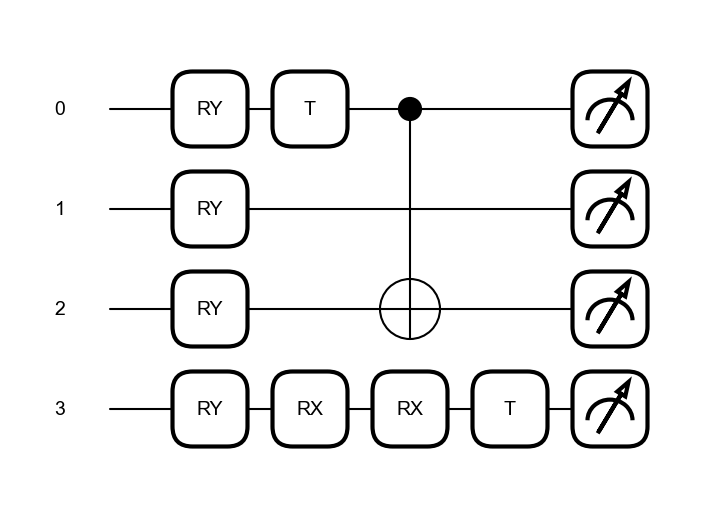

In [100]:
num = 21
circuit_to_test = final_population[0][0]
fig, ax = qml.draw_mpl(circuit)([1.0,4,54,44], circuit_to_test)
plt.savefig(f"./results/circuit{num}")
fig.show()

In [101]:
for gate in circuit_to_test:
    print(f"qml.{gate}")

qml.RX(2.808813842747843, wires=[3])
qml.T(wires=[0])
qml.RX(5.142911777869173, wires=[3])
qml.CNOT(wires=[0, 2])
qml.T(wires=[3])


In [102]:
n_epochs = 20
n_train = 500
n_test = 100

train_images, train_labels, test_images, test_labels = load_dataset(n_train, n_test)
q_train, q_test = quanvolute_train_test(train_images, test_images, circuit_to_test)

(500, 14, 14, 4)


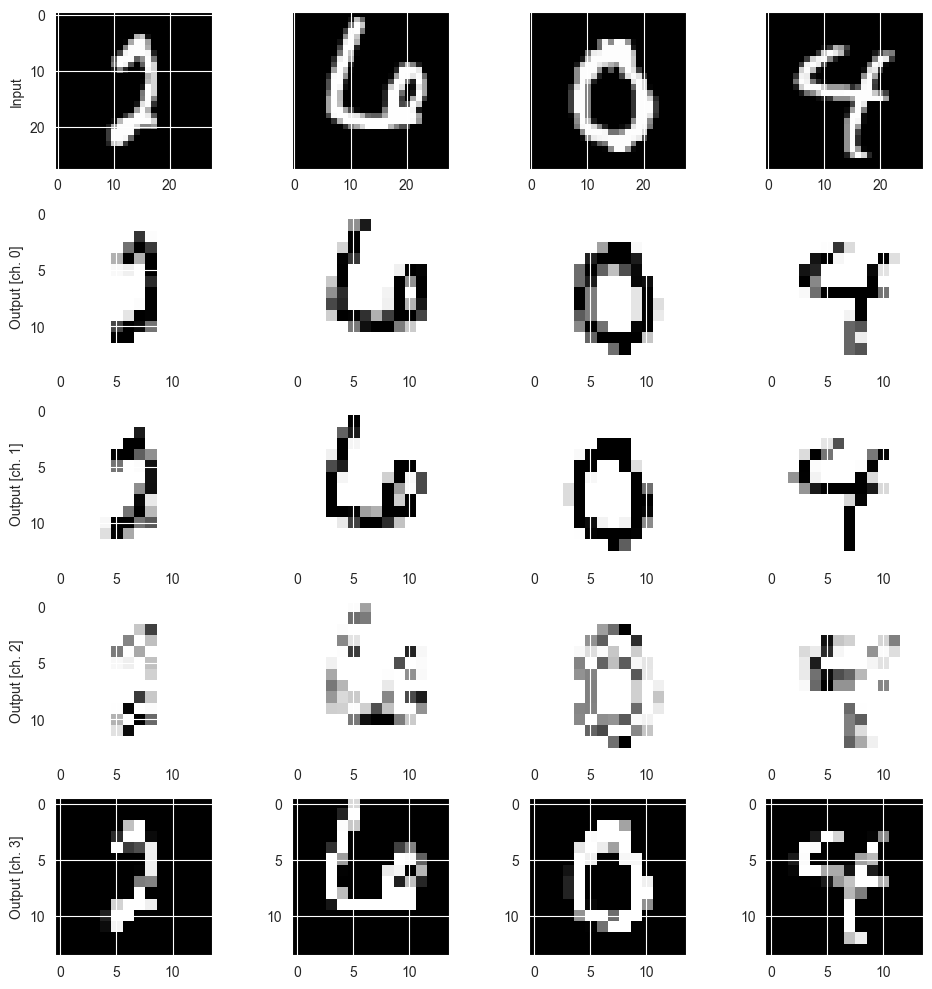

In [103]:
print(q_train.shape)

n_samples = 4
n_channels = 4
max_index = train_images.shape[0] - 1  

fig, axes = plt.subplots(1 + n_channels, n_samples, figsize=(10, 10))
random_indices = random.sample(range(max_index + 1), n_samples)  # Generate random indices

for k, index in enumerate(random_indices):  # Use indices instead of k directly
    axes[0, 0].set_ylabel("Input")
    if k != 0:
        axes[0, k].yaxis.set_visible(False)
    axes[0, k].imshow(train_images[index, :, :, 0], cmap="gray")

    # Plot all output channels
    for c in range(n_channels):
        axes[c + 1, 0].set_ylabel("Output [ch. {}]".format(c))
        if k != 0:
            axes[c, k].yaxis.set_visible(False)
        axes[c + 1, k].imshow(q_train[index, :, :, c], cmap="gray")

plt.tight_layout()
plt.savefig(f"./results/output{num}")
plt.show()

In [107]:
model1 = QNN()
hist1 = model1.fit(q_train, train_labels, validation_data = (q_test, test_labels), batch_size = batch_size, epochs=n_epochs, verbose=2)

Epoch 1/20
500/500 - 1s - loss: 4.1321 - accuracy: 0.4820 - val_loss: 2.9432 - val_accuracy: 0.6500 - 796ms/epoch - 2ms/step
Epoch 2/20
500/500 - 0s - loss: 2.5158 - accuracy: 0.6940 - val_loss: 2.7070 - val_accuracy: 0.6800 - 431ms/epoch - 863us/step
Epoch 3/20
500/500 - 0s - loss: 2.0582 - accuracy: 0.7520 - val_loss: 2.7615 - val_accuracy: 0.6600 - 281ms/epoch - 561us/step
Epoch 4/20
500/500 - 0s - loss: 1.6372 - accuracy: 0.7880 - val_loss: 1.9420 - val_accuracy: 0.7500 - 278ms/epoch - 556us/step
Epoch 5/20
500/500 - 0s - loss: 2.0165 - accuracy: 0.7740 - val_loss: 2.0678 - val_accuracy: 0.7500 - 280ms/epoch - 559us/step
Epoch 6/20
500/500 - 0s - loss: 1.3608 - accuracy: 0.8360 - val_loss: 1.7879 - val_accuracy: 0.8100 - 265ms/epoch - 530us/step
Epoch 7/20
500/500 - 0s - loss: 1.3891 - accuracy: 0.8620 - val_loss: 2.6872 - val_accuracy: 0.7900 - 268ms/epoch - 536us/step
Epoch 8/20
500/500 - 0s - loss: 0.8921 - accuracy: 0.8760 - val_loss: 2.3720 - val_accuracy: 0.8200 - 246ms/epoch

In [108]:
def CNN():
    optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=lr) 
    model = keras.models.Sequential([
        keras.layers.Conv2D(1, (2, 2), activation="relu", input_shape=(28, 28, 1)),
        keras.layers.Flatten(),
        keras.layers.Dense(10, activation="softmax")
    ])

    model.compile(
        optimizer=optimizer,
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

model2 = CNN()
hist2 = model2.fit(train_images, train_labels, validation_data = (test_images, test_labels), batch_size = batch_size, epochs=n_epochs, verbose=2)

Epoch 1/20
500/500 - 1s - loss: 1.0707 - accuracy: 0.6920 - val_loss: 0.6492 - val_accuracy: 0.7900 - 756ms/epoch - 2ms/step
Epoch 2/20
500/500 - 1s - loss: 0.4020 - accuracy: 0.8700 - val_loss: 0.5209 - val_accuracy: 0.8400 - 589ms/epoch - 1ms/step
Epoch 3/20
500/500 - 1s - loss: 0.2614 - accuracy: 0.9000 - val_loss: 0.5327 - val_accuracy: 0.8500 - 669ms/epoch - 1ms/step
Epoch 4/20
500/500 - 0s - loss: 0.1748 - accuracy: 0.9340 - val_loss: 0.6884 - val_accuracy: 0.8700 - 330ms/epoch - 659us/step
Epoch 5/20
500/500 - 0s - loss: 0.1343 - accuracy: 0.9500 - val_loss: 0.6408 - val_accuracy: 0.8500 - 305ms/epoch - 610us/step
Epoch 6/20
500/500 - 0s - loss: 0.0653 - accuracy: 0.9820 - val_loss: 0.9651 - val_accuracy: 0.8600 - 300ms/epoch - 599us/step
Epoch 7/20
500/500 - 0s - loss: 0.0524 - accuracy: 0.9820 - val_loss: 0.6206 - val_accuracy: 0.8800 - 307ms/epoch - 615us/step
Epoch 8/20
500/500 - 0s - loss: 0.0723 - accuracy: 0.9780 - val_loss: 1.0933 - val_accuracy: 0.8500 - 305ms/epoch - 6

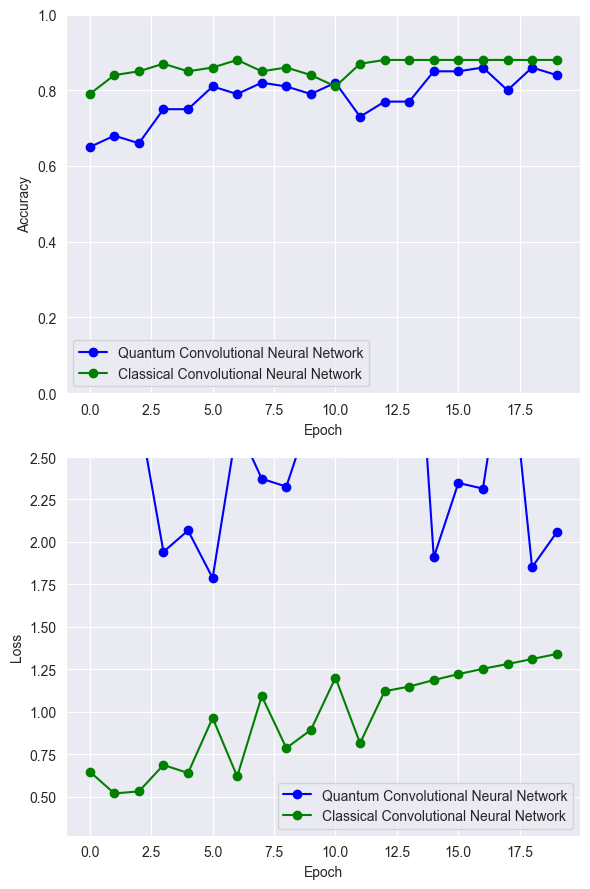

In [109]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 9))

ax1.plot(hist1.history["val_accuracy"], "-ob", label="Quantum Convolutional Neural Network")
ax1.plot(hist2.history["val_accuracy"], "-og", label="Classical Convolutional Neural Network")
ax1.set_ylabel("Accuracy")
ax1.set_ylim([0, 1])
ax1.set_xlabel("Epoch")
ax1.legend()

ax2.plot(hist1.history["val_loss"], "-ob", label="Quantum Convolutional Neural Network")
ax2.plot(hist2.history["val_loss"], "-og", label="Classical Convolutional Neural Network")
ax2.set_ylabel("Loss")
ax2.set_ylim(top=2.5)
ax2.set_xlabel("Epoch")
ax2.legend()
plt.savefig(f"./results/training{num}")
plt.tight_layout()
plt.show()